##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Pitch Detection

This colab will show you how to use the SPICE model downloaded from TensorFlow Hub.

In [7]:
!sudo apt-get install -q -y timidity libsndfile1

Reading package lists...
Building dependency tree...
Reading state information...
timidity is already the newest version (2.14.0-8ubuntu1).
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [8]:
# All the imports to deal with sound data
!pip install pydub librosa music21

In [9]:
# Install TensorFlow packages
!pip install tensorflow==2.13.1 ultralytics tflite_support_nightly

In [4]:
# Install CREPE
!pip install crepe

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

import crepe

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)

tensorflow: 2.13.1


In [ ]:
#@title Select the pitch detection algorithm (and version if using CREPE) { run: "auto" }
ALGORITHM = "SPICE" #@param ["SPICE", "CREPE", "Yin"]
if ALGORITHM == "CREPE":
  ALGORITHM_VERSION = 'tiny' #@param ["tiny", "small", "medium", "large", "full"]
print(f'You selected the {ALGORITHM} algorithm.')

# The audio input file
Now the hardest part: Record your singing! :)

We provide four methods to obtain an audio file:

1.   Record audio directly in colab
2.   Upload from your computer
3.   Use a file saved on Google Drive
4.   Download the file from the web

Choose one of the four methods below.

In [ ]:
#@title [Run this] Definition of the JS code to record audio straight from the browser

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
      f.write(b)
    return fname

In [ ]:
#@title Select how to input your audio  { run: "auto" }
INPUT_SOURCE = 'UPLOAD' #@param ["https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav", "RECORD", "UPLOAD", "./drive/My Drive/YOUR_MUSIC_FILE.wav"] {allow-input: true}

print('You selected', INPUT_SOURCE)

if INPUT_SOURCE == 'RECORD':
  uploaded_file_name = record(5)
elif INPUT_SOURCE == 'UPLOAD':
  try:
    from google.colab import files
  except ImportError:
    print("ImportError: files from google.colab seems to not be available")
  else:
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    uploaded_file_name = next(iter(uploaded))
    print('Uploaded file: ' + uploaded_file_name)
elif INPUT_SOURCE.startswith('./drive/'):
  try:
    from google.colab import drive
  except ImportError:
    print("ImportError: files from google.colab seems to not be available")
  else:
    drive.mount('/content/drive')
    # don't forget to change the name of the file you
    # will you here!
    gdrive_audio_file = 'YOUR_MUSIC_FILE.wav'
    uploaded_file_name = INPUT_SOURCE
elif INPUT_SOURCE.startswith('http'):
  !wget --no-check-certificate 'https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav' -O c-scale.wav
  uploaded_file_name = 'c-scale.wav'
elif INPUT_SOURCE.endswith('.wav'):
  uploaded_file_name = INPUT_SOURCE
else:
  print('Unrecognized input format!')
  print('Please select "RECORD", "UPLOAD", or specify a file hosted on Google Drive or a file from the web to download file to download')

You selected UPLOAD


Saving LeadVoxREC_1.wav to LeadVoxREC_1.wav
User uploaded file "LeadVoxREC_1.wav" with length 6226646 bytes
Uploaded file: LeadVoxREC_1.wav


# Preparing the audio data

Now we have the audio, let's convert it to the expected format and then listen to it!

The SPICE model needs as input an audio file at a sampling rate of 16kHz and with only one channel (mono).

To help you with this part, we created a function (`convert_audio_for_model`) to convert any wav file you have to the model's expected format:

In [ ]:
# Function that converts the user-created audio to the format that the model
# expects: bitrate 16kHz and only one channel (mono).

EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [ ]:
# Converting to the expected format for the model
# in all the input 4 input method before, the uploaded file name is at
# the variable uploaded_file_name
converted_audio_file = convert_audio_for_model(uploaded_file_name)

In [ ]:
# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

# Let's listen to the wav file.
#Audio(audio_samples, rate=sample_rate)
startSample = 540000
window = 40 # audio snippet in ms
endSample = startSample + int((window * sample_rate)/1000) - 1
Audio(audio_samples[startSample:endSample], rate=sample_rate)
audio_samples = audio_samples[startSample:endSample]

Sample rate: 16000 Hz
Total duration: 70.59s
Size of the input: 1129412


First thing, let's take a look at the waveform of our singing.

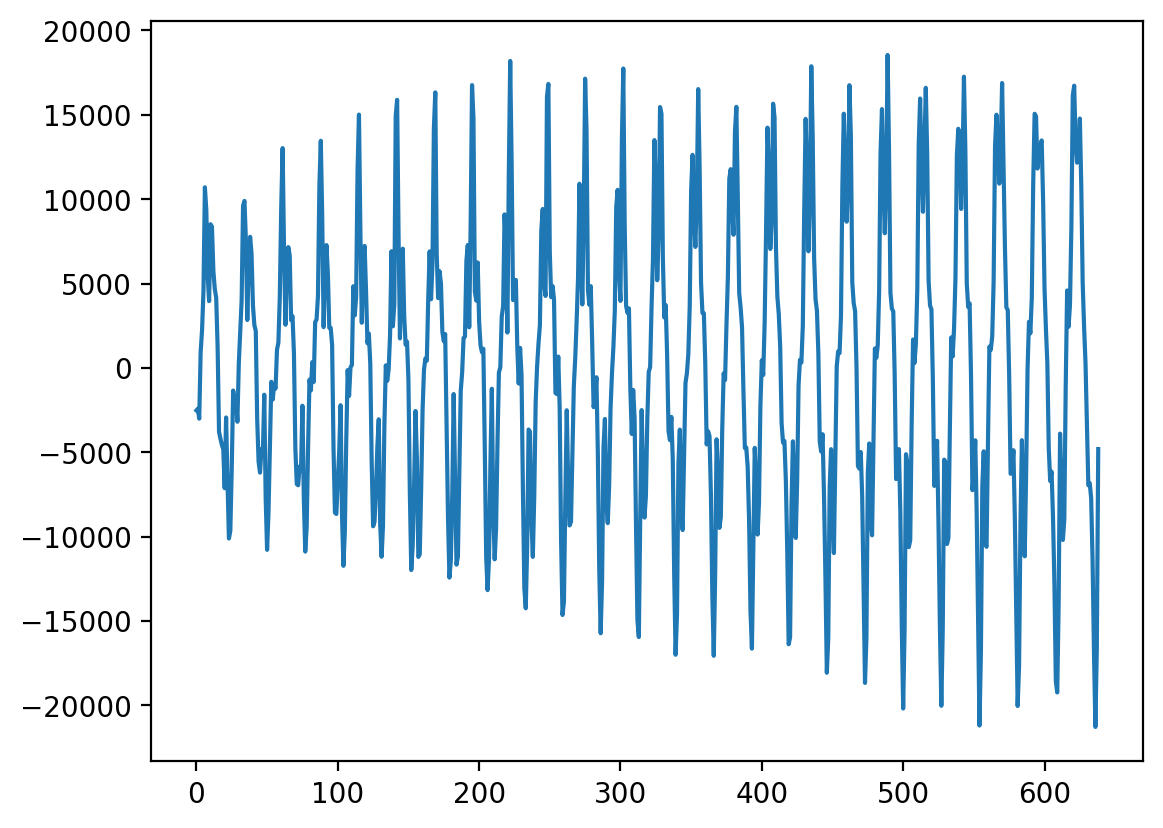

In [ ]:
# We can visualize the audio as a waveform.
_ = plt.plot(audio_samples)

A more informative visualization is the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), which shows frequencies present over time.

Here, we use a logarithmic frequency scale, to make the singing more clearly visible.


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=639
  warnings.warn(


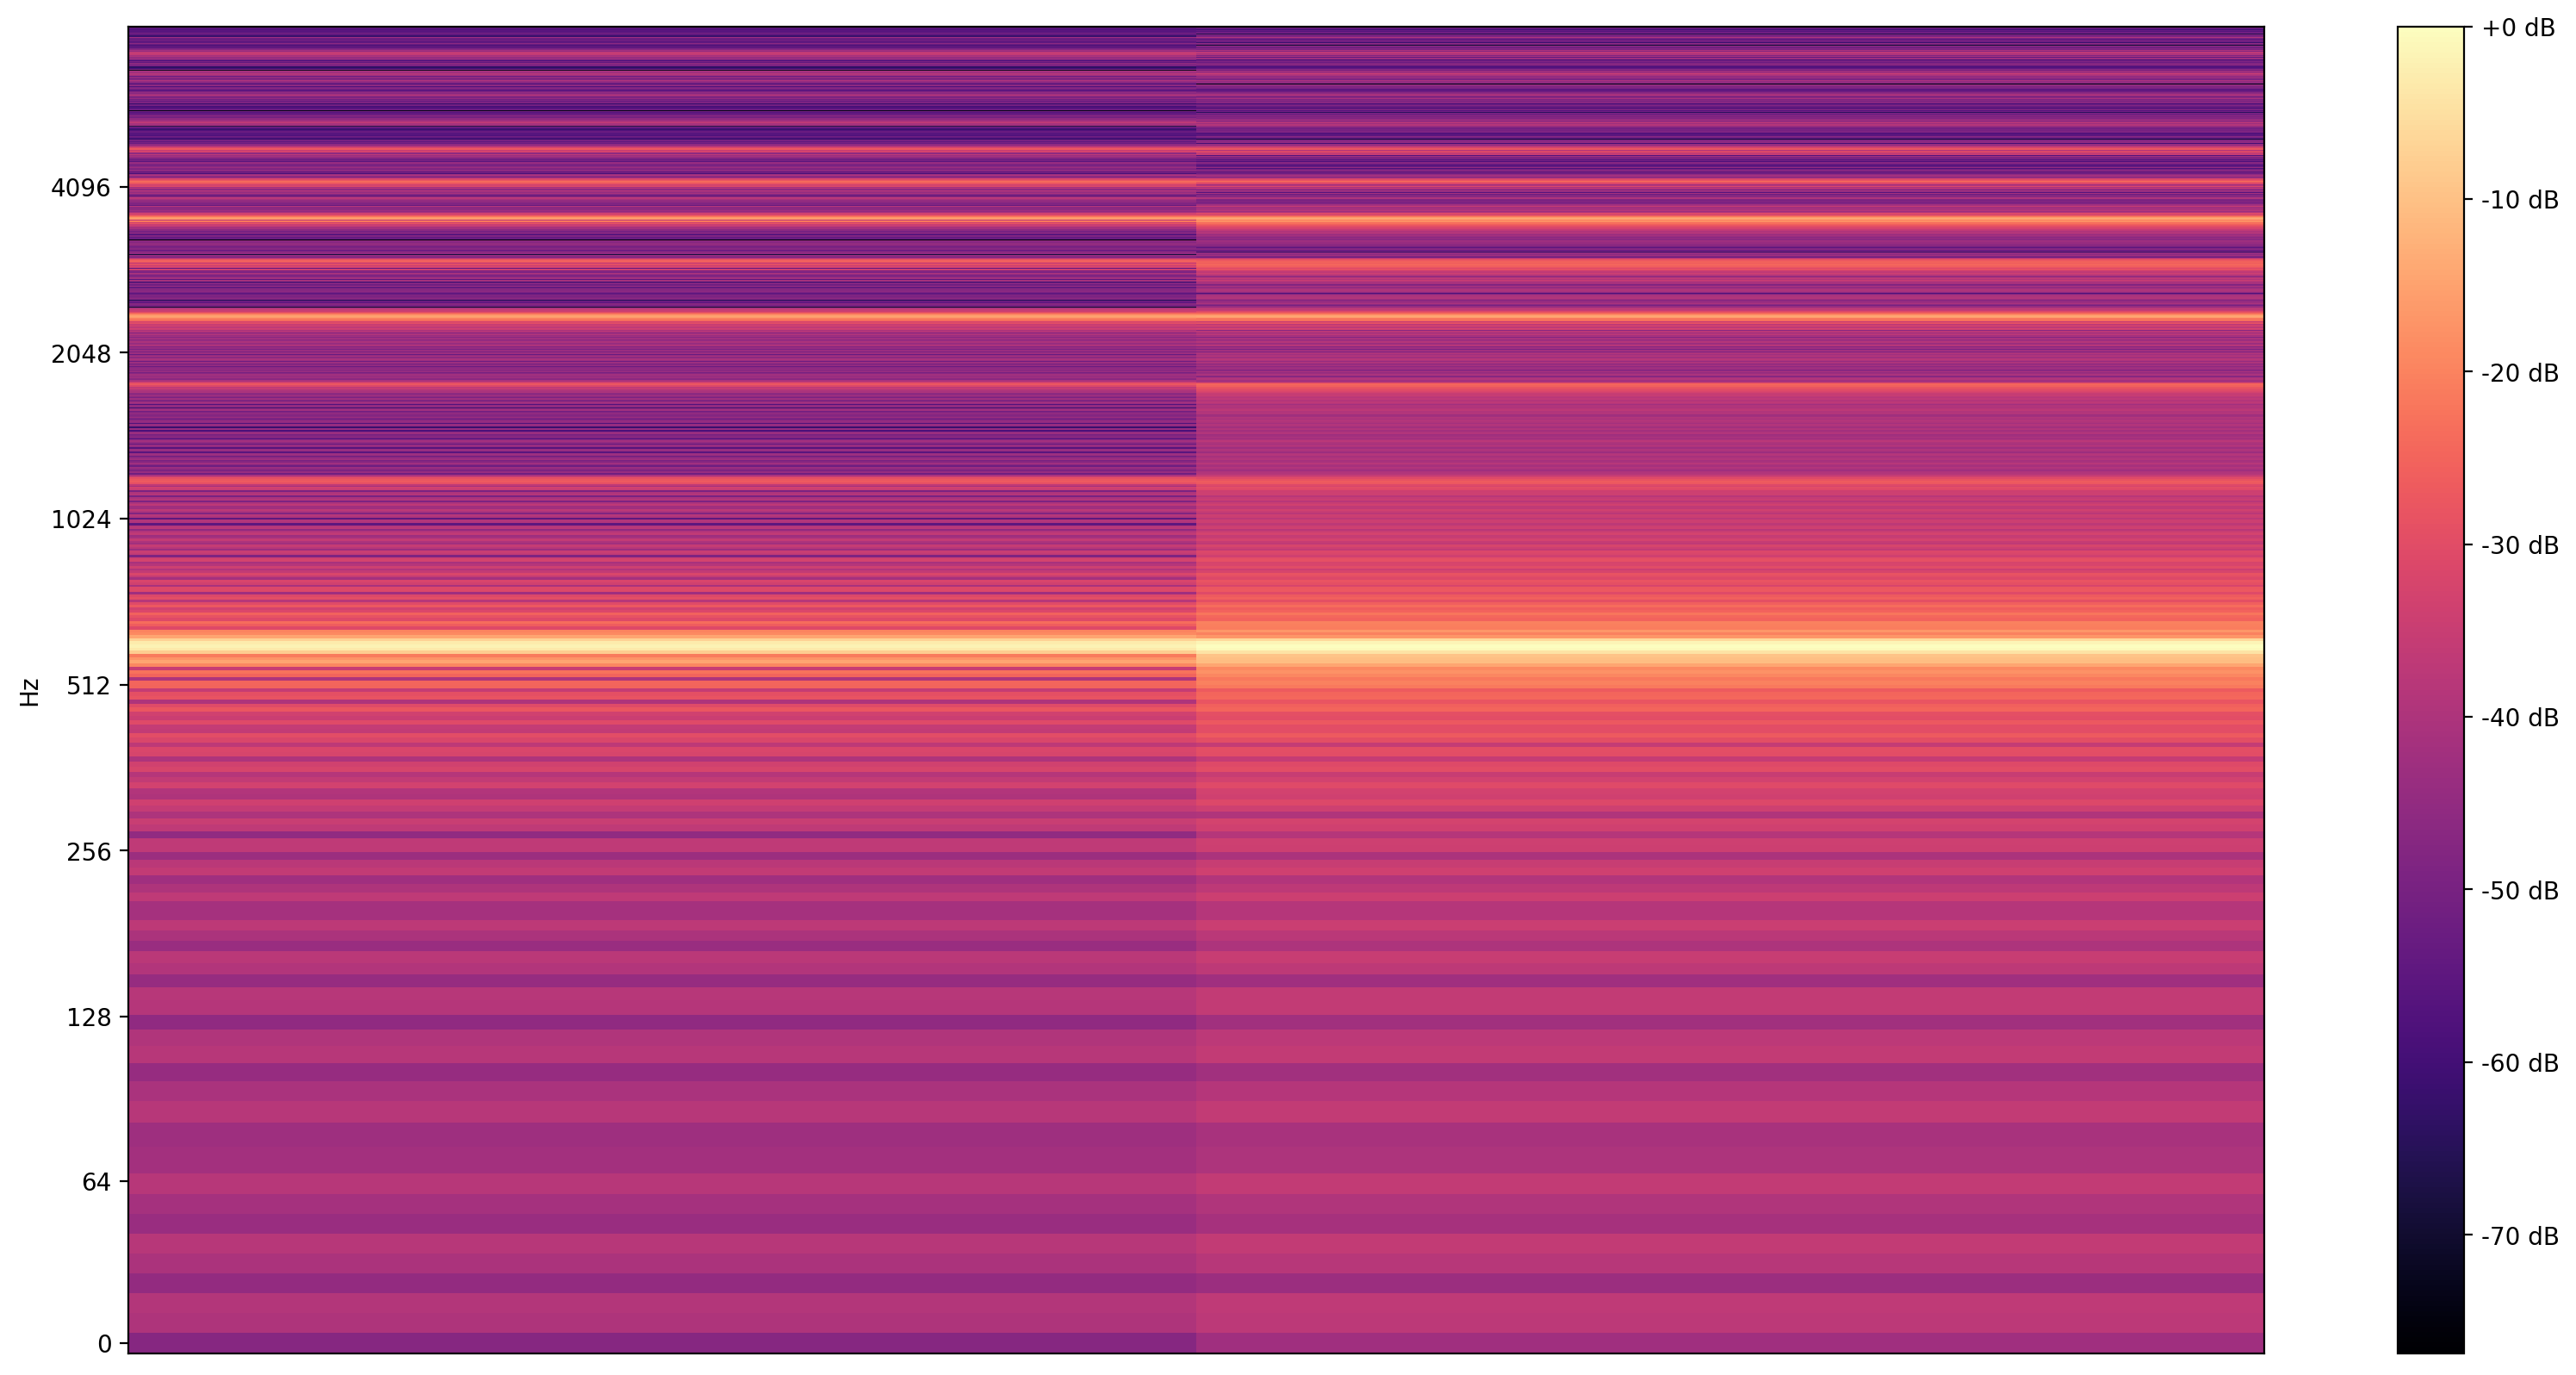

In [ ]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
  x_stft = np.abs(librosa.stft(x, n_fft=2048))
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)
  if(show_black_and_white):
    librosadisplay.specshow(data=x_stft_db, y_axis='log',
                             sr=sample_rate, cmap='gray_r')
  else:
    librosadisplay.specshow(data=x_stft_db, y_axis='log', sr=sample_rate)

  plt.colorbar(format='%+2.0f dB')

plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)
plt.show()


We need one last conversion here. The audio samples are in int16 format. They need to be normalized to floats between -1 and 1.

In [ ]:
audio_samples = audio_samples / float(MAX_ABS_INT16)

# Executing the Model
Now is the easy part, let's load the model with **TensorFlow Hub**, and feed the audio to it.
SPICE will give us two outputs: pitch and uncertainty


**TensorFlow Hub** is a library for the publication, discovery, and consumption of reusable parts of machine learning models. It makes easy to use machine learning to solve your challenges.

To load the model you just need the Hub module and the URL pointing to the model:

In [ ]:
# normalize the Hz output from CREPE and Yin to 0..1, like SPICE
def crepeOutputNorm(hertz_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  pitch_output = BINS_PER_OCTAVE * math.log2(hertz_output/FMIN)
  # cqt_bin = hertz_output * PT_SLOPE + PT_OFFSET;
  return (pitch_output - PT_OFFSET)/PT_SLOPE

if (ALGORITHM == "SPICE"):
  # Loading the SPICE model is easy:
  model = hub.load("https://tfhub.dev/google/spice/2")
  CONFIDENCE_THRESHOLD = 0.9
elif (ALGORITHM == "CREPE"):
  model = crepe
  STEP_SIZE = 32 # step size in ms, match the value used by SPICE
  if ALGORITHM_VERSION == 'tiny':
    CONFIDENCE_THRESHOLD = 0.75
  elif ALGORITHM_VERSION == 'small':
    CONFIDENCE_THRESHOLD = 0.75
  elif ALGORITHM_VERSION == 'medium':
    CONFIDENCE_THRESHOLD = 0.8
  elif ALGORITHM_VERSION == 'large':
    CONFIDENCE_THRESHOLD = 0.8
  elif ALGORITHM_VERSION == 'full':
    CONFIDENCE_THRESHOLD = 0.85

elif (ALGORITHM == "Yin"):
  def differenceFunction(x, N, tau_max):
    """
    Compute difference function of data x. This corresponds to equation (6) in [1]

    Fastest implementation. Use the same approach than differenceFunction_scipy.
    This solution is implemented directly with Numpy fft.


    :param x: audio data
    :param N: length of data
    :param tau_max: integration window size
    :return: difference function
    :rtype: list
    """

    x = np.array(x, np.float64)
    w = x.size
    tau_max = min(tau_max, w)
    x_cumsum = np.concatenate((np.array([0.]), (x * x).cumsum()))
    size = w + tau_max
    p2 = (size // 32).bit_length()
    nice_numbers = (16, 18, 20, 24, 25, 27, 30, 32)
    size_pad = min(x * 2 ** p2 for x in nice_numbers if x * 2 ** p2 >= size)
    fc = np.fft.rfft(x, size_pad)
    conv = np.fft.irfft(fc * fc.conjugate())[:tau_max]
    return x_cumsum[w:w - tau_max:-1] + x_cumsum[w] - x_cumsum[:tau_max] - 2 * conv

  def cumulativeMeanNormalizedDifferenceFunction(df, N):
    """
    Compute cumulative mean normalized difference function (CMND).

    This corresponds to equation (8) in [1]

    :param df: Difference function
    :param N: length of data
    :return: cumulative mean normalized difference function
    :rtype: list
    """

    cmndf = df[1:] * range(1, N) / np.cumsum(df[1:]).astype(float) #scipy method
    return np.insert(cmndf, 0, 1)

  def getPitch(cmdf, tau_min, tau_max, harmo_th=0.1):
    """
    Return fundamental period of a frame based on CMND function.

    :param cmdf: Cumulative Mean Normalized Difference function
    :param tau_min: minimum period for speech
    :param tau_max: maximum period for speech
    :param harmo_th: harmonicity threshold to determine if it is necessary to compute pitch frequency
    :return: fundamental period if there is values under threshold, 0 otherwise
    :rtype: float
    """
    tau = tau_min
    while tau < tau_max:
        if cmdf[tau] < harmo_th:
            while tau + 1 < tau_max and cmdf[tau + 1] < cmdf[tau]:
                tau += 1
            return tau
        tau += 1

    return 0    # if unvoiced

  def compute_yin(sig, sr, dataFileName=None, w_len=512, w_step=256, f0_min=100, f0_max=500, harmo_thresh=0.1):
    """

    Compute the Yin Algorithm. Return fundamental frequency and harmonic rate.

    :param sig: Audio signal (list of float)
    :param sr: sampling rate (int)
    :param w_len: size of the analysis window (samples)
    :param w_step: size of the lag between two consecutives windows (samples)
    :param f0_min: Minimum fundamental frequency that can be detected (hertz)
    :param f0_max: Maximum fundamental frequency that can be detected (hertz)
    :param harmo_tresh: Threshold of detection. The yalgorithmù return the first minimum of the CMND fubction below this treshold.

    :returns:

        * pitches: list of fundamental frequencies,
        * harmonic_rates: list of harmonic rate values for each fundamental frequency value (= confidence value)
        * argmins: minimums of the Cumulative Mean Normalized DifferenceFunction
        * times: list of time of each estimation
    :rtype: tuple
    """

    print('Yin: compute yin algorithm')
    tau_min = int(sr / f0_max)
    tau_max = int(sr / f0_min)

    timeScale = range(0, len(sig) - w_len, w_step)  # time values for each analysis window
    times = [t/float(sr) for t in timeScale]
    frames = [sig[t:t + w_len] for t in timeScale]

    pitches = [0.0] * len(timeScale)
    harmonic_rates = [0.0] * len(timeScale)
    argmins = [0.0] * len(timeScale)

    for i, frame in enumerate(frames):

        #Compute YIN
        df = differenceFunction(frame, w_len, tau_max)
        cmdf = cumulativeMeanNormalizedDifferenceFunction(df, tau_max)
        p = getPitch(cmdf, tau_min, tau_max, harmo_thresh)

        #Get results
        if np.argmin(cmdf)>tau_min:
            argmins[i] = float(sr / np.argmin(cmdf))
        if p != 0: # A pitch was found
            pitches[i] = float(sr / p)
            harmonic_rates[i] = cmdf[p]
        else: # No pitch, but we compute a value of the harmonic rate
            harmonic_rates[i] = min(cmdf)


    if dataFileName is not None:
        np.savez(dataFileName, times=times, sr=sr, w_len=w_len, w_step=w_step, f0_min=f0_min, f0_max=f0_max, harmo_thresh=harmo_thresh, pitches=pitches, harmonic_rates=harmonic_rates, argmins=argmins)
        print('\t- Data file written in: ' + dataFileName)

    return pitches, harmonic_rates, argmins, times

  model = compute_yin
  CONFIDENCE_THRESHOLD = 0.25
  W_STEP = int((32*sample_rate)/1000) # 32 ms in samples
  W_LEN = 2*W_STEP
  FO_MIN = 25.0
  FO_MAX = 8000.0
  HARMO_THRESHOLD = CONFIDENCE_THRESHOLD


**Note:** An interesting detail here is that all the model urls from Hub can be used for download and also to read the documentation, so if you point your browser to that link you can read documentation on how to use the model and learn more about how it was trained.

With the model loaded, data prepared, we need 3 lines to get the result:

In [ ]:
import datetime
if (ALGORITHM == "SPICE"):
  # We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
  start_time = datetime.datetime.now()
  model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))
  end_time = datetime.datetime.now()
  pitch_outputs = model_output["pitch"]
  uncertainty_outputs = model_output["uncertainty"]
elif (ALGORITHM == "CREPE"):
  start_time = datetime.datetime.now()
  time, frequency, confidence, activation = model.predict(audio_samples, sample_rate, step_size=32, model_capacity=ALGORITHM_VERSION)
  end_time = datetime.datetime.now()
  pitch_outputs = [crepeOutputNorm(f) for f in frequency ]
  uncertainty_outputs = 1.0 - confidence
elif (ALGORITHM == "Yin"):
  start_time = datetime.datetime.now()
  pitches, harmonic_rates, argmins, times = compute_yin(audio_samples, sample_rate, "YinOutput.log", W_LEN, W_STEP, FO_MIN, FO_MAX, HARMO_THRESHOLD)
  end_time = datetime.datetime.now()
  pitch_outputs = [crepeOutputNorm(f) for f in pitches if f>0]
  uncertainty_outputs = 1.0 - np.array(harmonic_rates, dtype=float)

print (f"Time required for running {ALGORITHM}: {end_time - start_time}")
# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

Time required for running SPICE: 0:00:00.259003


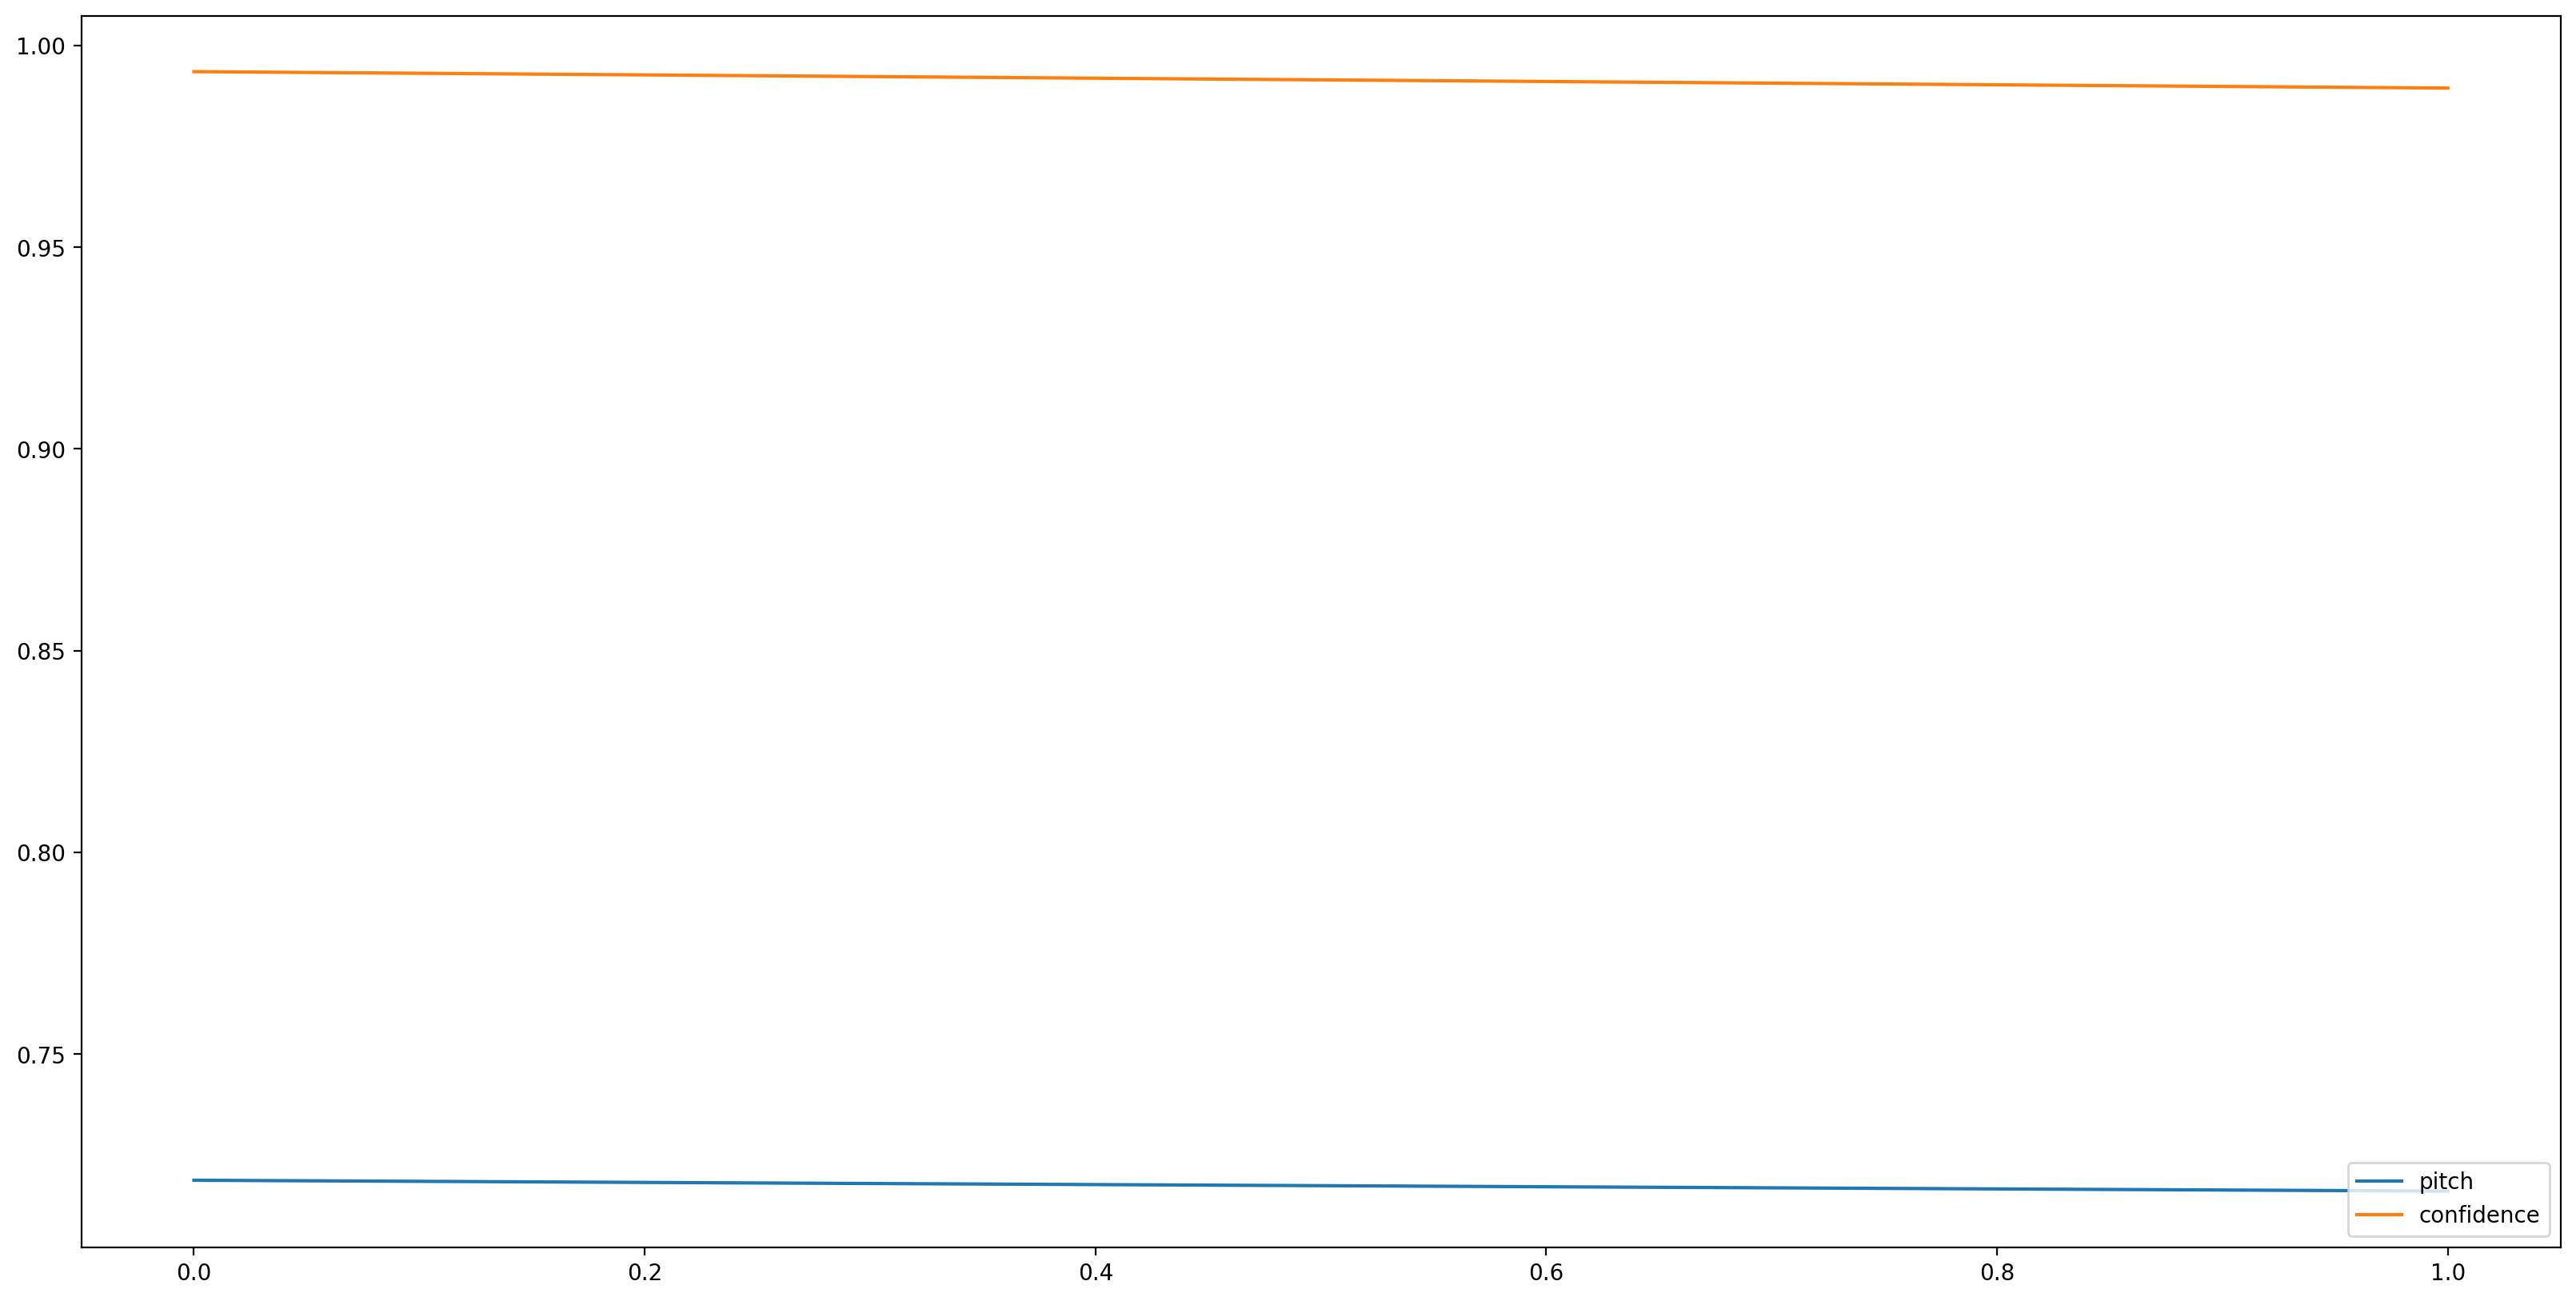

In [ ]:
# Display model pitch and confidence outputs
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitch_outputs, label='pitch')
plt.plot(confidence_outputs, label='confidence')
plt.legend(loc="lower right")
plt.show()

Let's make the results easier to understand by removing all pitch estimates with low confidence (confidence < 0.9) and plot the remaining ones.


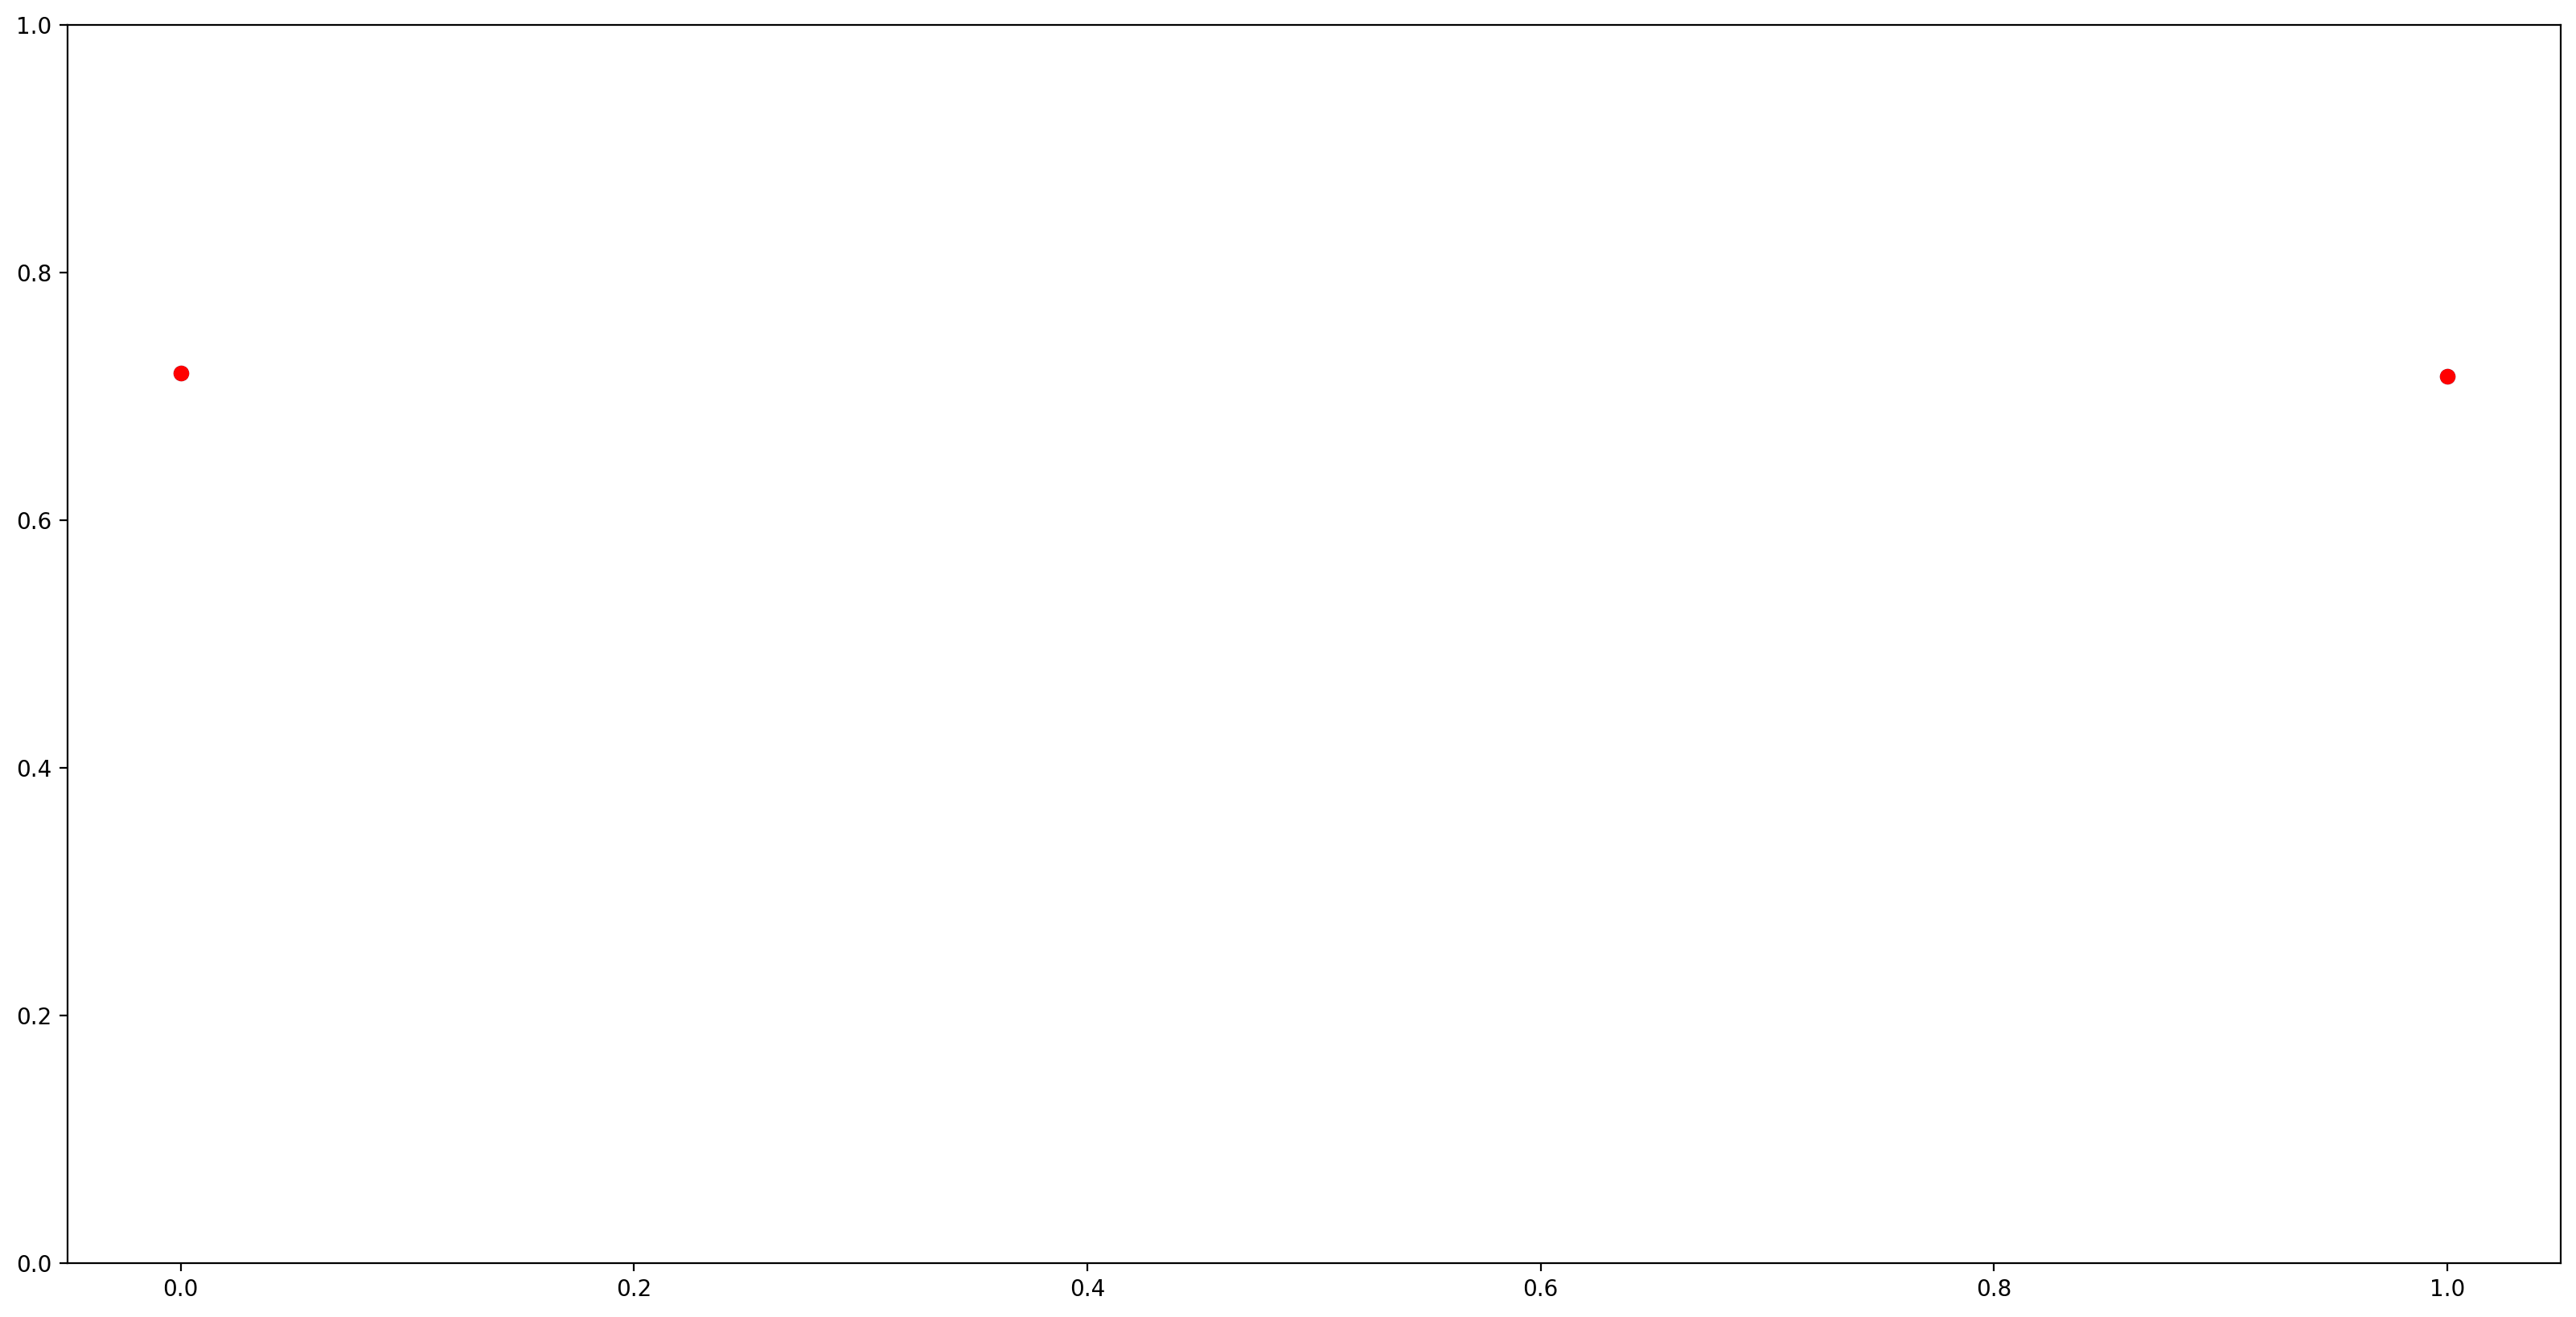

In [ ]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= CONFIDENCE_THRESHOLD]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

plt.show()

The pitch values returned by SPICE are in the range from 0 to 1. Let's convert them to absolute pitch values in Hz.

In [ ]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

Now, let's see how good the prediction is: We will overlay the predicted pitches over the original spectrogram. To make the pitch predictions more visible, we changed the spectrogram to black and white.

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=639
  warnings.warn(


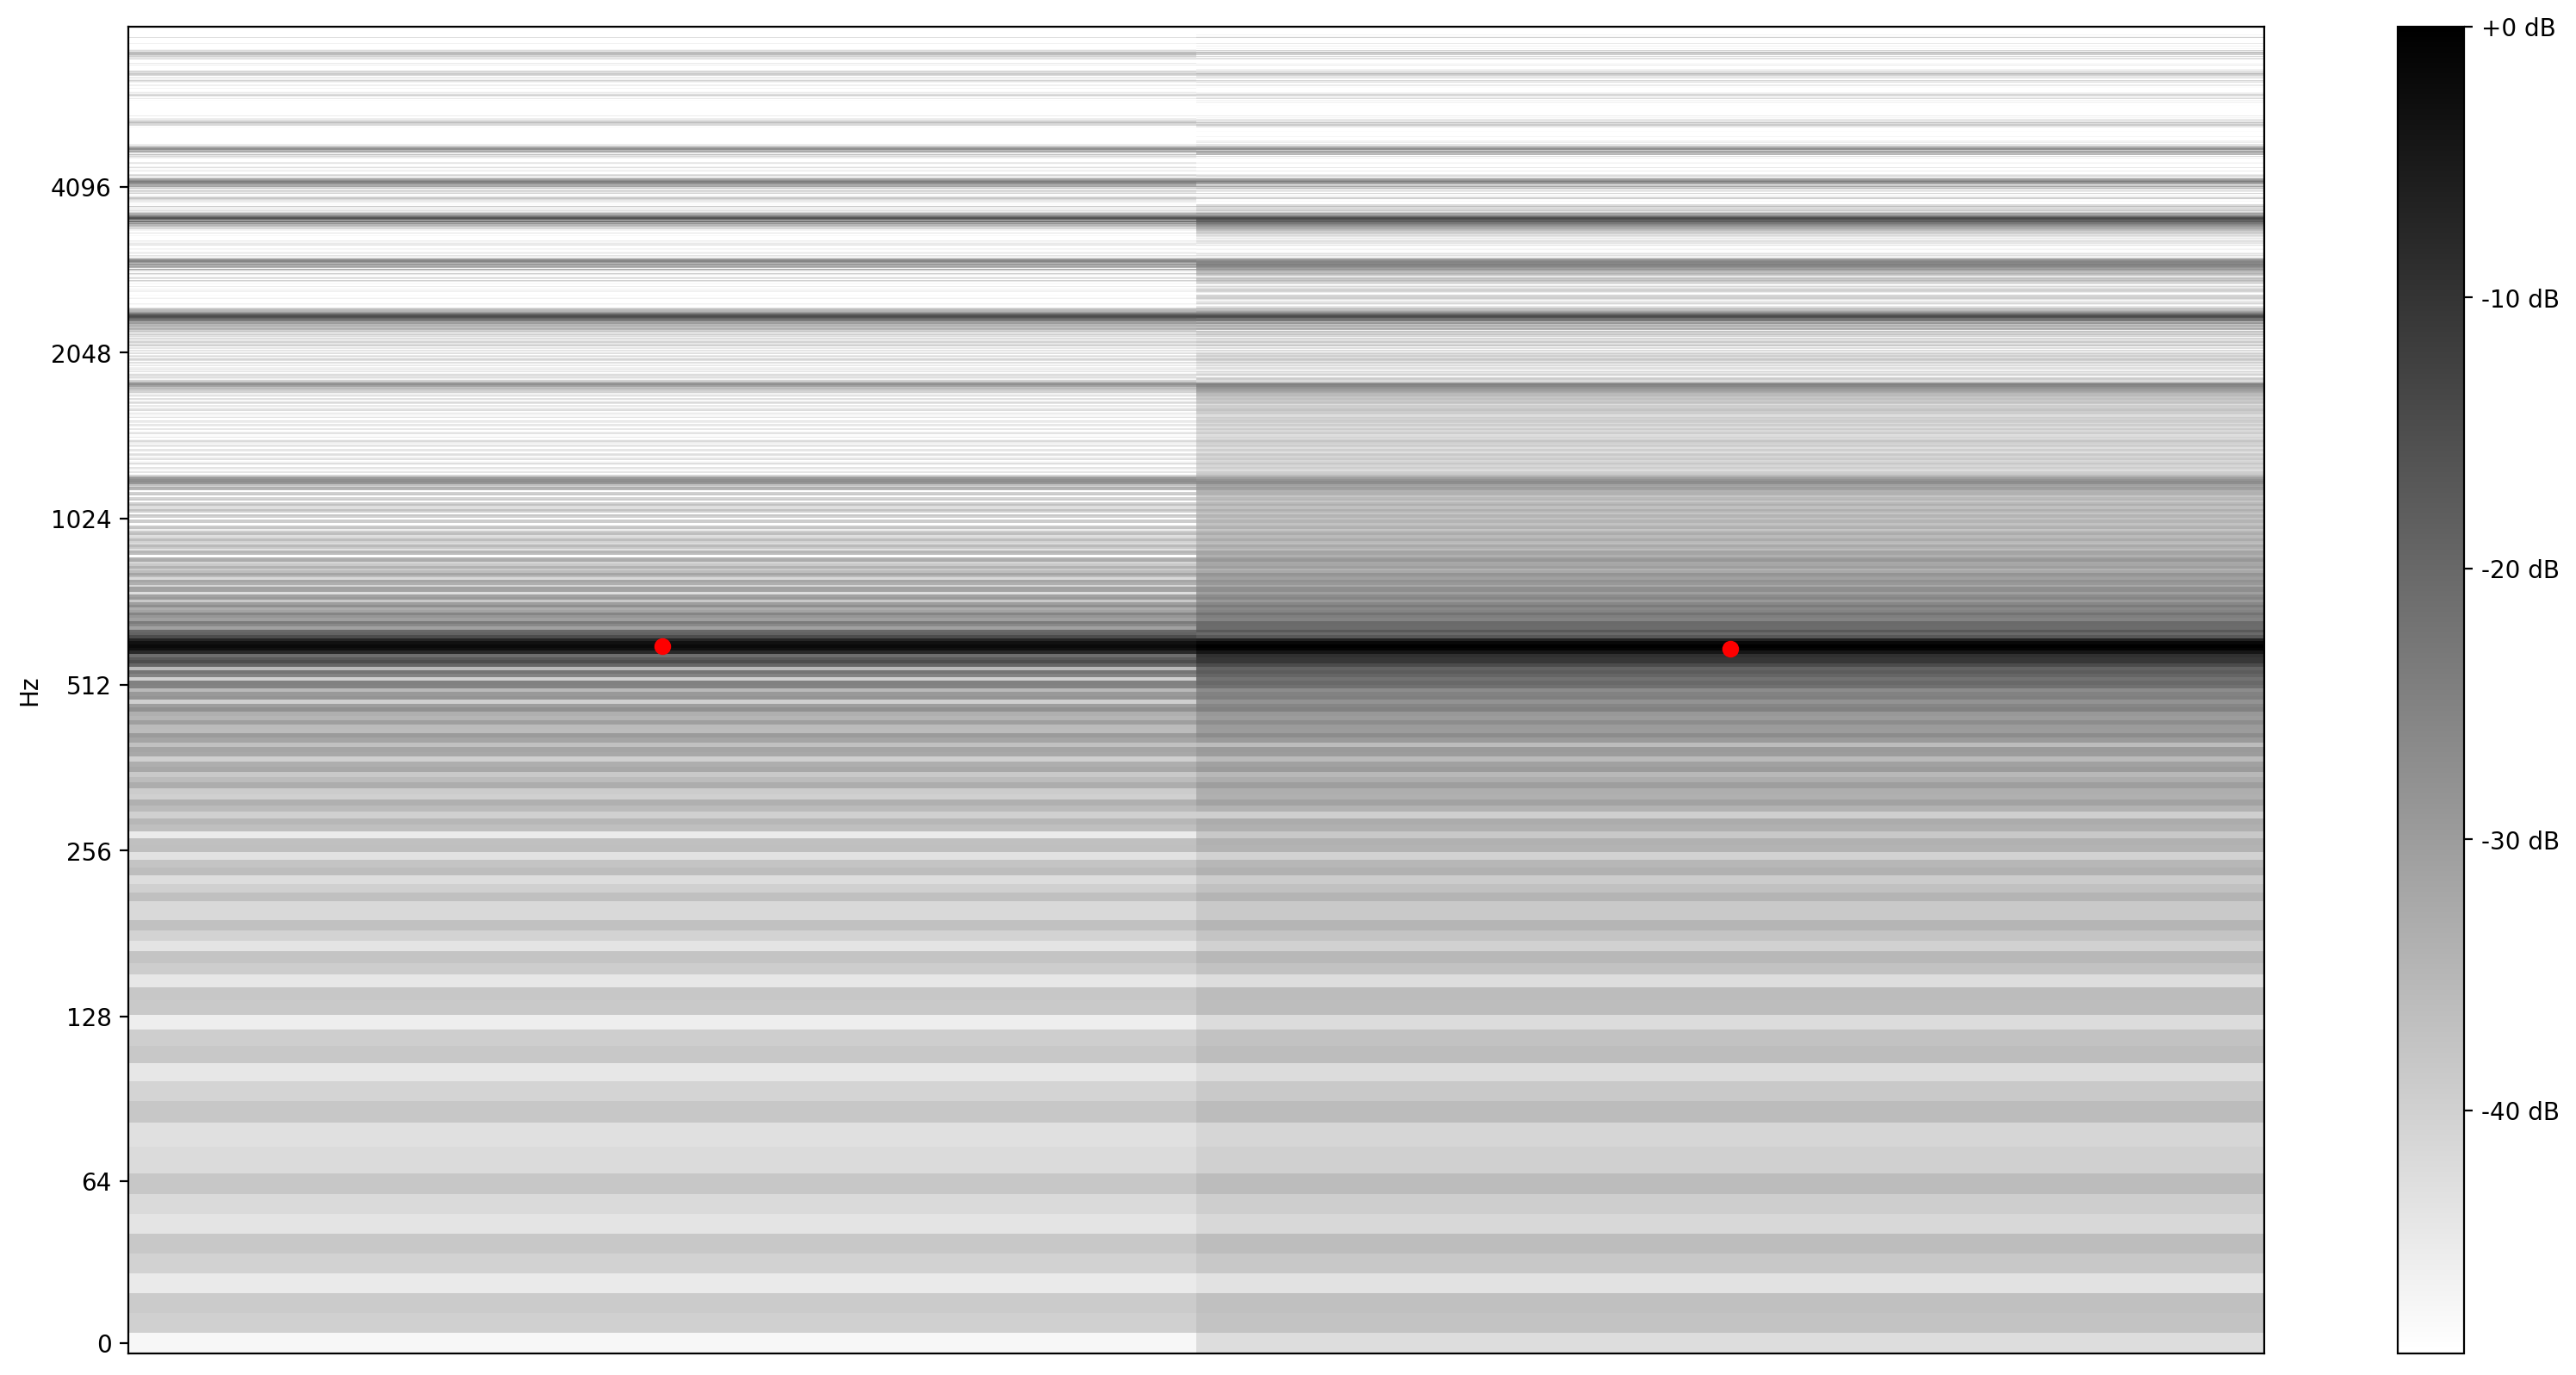

In [ ]:
plot_stft(audio_samples / MAX_ABS_INT16 ,
          sample_rate=EXPECTED_SAMPLE_RATE, show_black_and_white=True)
# Note: conveniently, since the plot is in log scale, the pitch outputs
# also get converted to the log scale automatically by matplotlib.
plt.scatter(confident_pitch_outputs_x, confident_pitch_values_hz, c="r")

plt.show()

# Convert SPICE to TFLite


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('archive') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)



# Add Model Metadata

In [62]:
from tflite_support.metadata_writers import audio_classifier
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils
from tflite_support import metadata as _metadata
from tflite_support import flatbuffers
from tensorflow_lite_support.metadata.python.metadata_writers import metadata_writer
from tflite_support import metadata_schema_py_generated as _metadata_fb

AudioClassifierWriter = audio_classifier.MetadataWriter
MetadataWriter = metadata_writer.MetadataWriter

_MODEL_PATH = "1.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = ""
# Expected sampling rate of the input audio buffer.
_SAMPLE_RATE = 16000
# Expected number of channels of the input audio buffer. Note, Task library only
# support single channel so far.
_CHANNELS = 1
_SAVE_TO_PATH = "spice_metadata.tflite"

_INPUT_NAME = "audio_clip"
_INPUT_DESCRIPTION = "Input audio clip to be classified."
_OUTPUT_NAME_UNCERTAINTIES = "uncertainties"
_OUTPUT_DESCRIPTION_UNCERTAINTIES = "A list of values in the interval [0, 1], each of which corresponds to the uncertainty of the model in getting the pitch prediction correct."
_OUTPUT_NAME_PITCHES = "pitches"
_OUTPUT_DESCRIPTION_PITCHES = "A list of values in the interval [0, 1], each of which corresponds to the pitch of the input audio. The output value needs to be calibrated (with a little labeled data) to obtain the pitch in semitones."

model_buffer = writer_utils.load_file(_MODEL_PATH)
input_md = metadata_info.InputAudioTensorMd(_INPUT_NAME, _INPUT_DESCRIPTION,
                                                _SAMPLE_RATE, _CHANNELS)
# uncertainties_assoc = AssociatedFile()
# output_meta = _metadata_fb.TensorMetadataT()
# label_file = _metadata_fb.AssociatedFileT()
# label_file.name = "your_path_to_label_file"
# label_file.description = "Labels for objects that the model can recognize."
# label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
# output_meta.associatedFiles = [label_file]


# uncertainties_label = metadata_info.LabelFileMd('uncertainty_label.txt')
# output_md_uncertainties = metadata_info.ClassificationTensorMd(
#     name=_OUTPUT_NAME_UNCERTAINTIES,
#     description=_OUTPUT_DESCRIPTION_UNCERTAINTIES,
#     label_files=[],
#     tensor_type=writer_utils.get_output_tensor_types(model_buffer)[0],
#     score_calibration_md=None)

# # output_md_uncertainties.associated_files = label_file

# pitch_label = metadata_info.LabelFileMd('pitch_label.txt')
# output_md_pitches = metadata_info.ClassificationTensorMd(
#     name=_OUTPUT_NAME_PITCHES,
#     description=_OUTPUT_DESCRIPTION_PITCHES,
#     label_files=[],
#     tensor_type=writer_utils.get_output_tensor_types(model_buffer)[1],
#     score_calibration_md=None)

# output_md_uncertainties.shape = (1, 1, 10000)
# output_md_pitches.shape = (1, 1, 10000)

#  """A container for common tensor metadata information.

#   Attributes:
#     name: name of the tensor.
#     description: description of what the tensor is.
#     min_values: per-channel minimum value of the tensor.
#     max_values: per-channel maximum value of the tensor.
#     content_type: content_type of the tensor.
#     associated_files: information of the associated files in the tensor.
#     tensor_name: name of the corresponding tensor [1] in the TFLite model. It is
#       used to locate the corresponding tensor and decide the order of the tensor
#       metadata [2] when populating model metadata.
#     [1]:
#       https://github.com/tensorflow/tensorflow/blob/cb67fef35567298b40ac166b0581cd8ad68e5a3a/tensorflow/lite/schema/schema.fbs#L1129-L1136
#     [2]:
#       https://github.com/tensorflow/tflite-support/blob/b2a509716a2d71dfff706468680a729cc1604cff/tensorflow_lite_support/metadata/metadata_schema.fbs#L595-L612
#   """

# output_md_uncertainties = metadata_info.TensorMd(
#     name=_OUTPUT_NAME_UNCERTAINTIES,
#     description=_OUTPUT_DESCRIPTION_UNCERTAINTIES,
#     min_values=[0.0],
#     max_values=[1.0])

# output_md_pitches = metadata_info.TensorMd(
#     name=_OUTPUT_NAME_PITCHES,
#     description=_OUTPUT_DESCRIPTION_PITCHES,
#     min_values=[0.0],
#     max_values=[1.0])

# Load your TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=_MODEL_PATH)
interpreter.allocate_tensors()

# Create a metadata writer
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "SPICE"
model_meta.version = "V2"
model_meta.author = "TensorFlow"
model_meta.license = "Apache License. Version 2.0 http://www.apache.org/licenses/LICENSE-2.0."

# Get the input tensor details
input_details = interpreter.get_input_details()

# Input tensor
input_tensor = input_details[0]

# Define the output tensor metadata
input_tensor_meta = _metadata_fb.TensorMetadataT()
input_tensor_meta.name = _INPUT_NAME
input_tensor_meta.description = _INPUT_DESCRIPTION

# Define the input tensor shape
input_shape = input_tensor['shape']
input_tensor_meta.content = _metadata_fb.ContentT()
builder = flatbuffers.Builder(0)
input_tensor_meta.content.contentProperties = _metadata_fb.AudioProperties()

audio_props = _metadata_fb.AudioPropertiesStart(builder)
audio_props.AudioPropertiesAddSampleRate(16000)
# def AudioPropertiesAddSampleRate(builder, sampleRate):
#     builder.PrependUint32Slot(0, sampleRate, 0)

# def AudioPropertiesAddChannels(builder, channels):
#     builder.PrependUint32Slot(1, channels, 0)

# def AudioPropertiesEnd(builder):
#     return builder.EndObject()

input_tensor_meta.content.contentProperties.dimensions = input_shape
input_tensor_meta.content.contentProperties.channels = 1
input_tensor_meta.content.contentProperties.sample_rate = _SAMPLE_RATE

_metadata_fb.AudioProperties()
# Input normalizations
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_tensor_meta.processUnits = [input_normalization]

# Input stats
input_stats = _metadata_fb.StatsT()
input_stats.max = [1]
input_stats.min = [-1]
input_tensor_meta.stats = input_stats

# Add the input tensor metadata to the model metadata
model_meta.inputTensorMetadata = [input_tensor_meta]

# Creates outputs info.
# output_location_meta = _metadata_fb.TensorMetadataT()
# output_location_meta.name = "location"
# output_location_meta.description = "The locations of the detected boxes."
# output_location_meta.content = _metadata_fb.ContentT()
# output_location_meta.content.contentPropertiesType = (
#     _metadata_fb.ContentProperties.BoundingBoxProperties)
# output_location_meta.content.contentProperties = (
#     _metadata_fb.BoundingBoxPropertiesT())
# output_location_meta.content.contentProperties.index = [1, 0, 3, 2]
# output_location_meta.content.contentProperties.type = (
#     _metadata_fb.BoundingBoxType.BOUNDARIES)
# output_location_meta.content.contentProperties.coordinateType = (
#     _metadata_fb.CoordinateType.RATIO)
# output_location_meta.content.range = _metadata_fb.ValueRangeT()
# output_location_meta.content.range.min = 2
# output_location_meta.content.range.max = 2

# output_class_meta = _metadata_fb.TensorMetadataT()
# output_class_meta.name = "category"
# output_class_meta.description = "The categories of the detected boxes."
# output_class_meta.content = _metadata_fb.ContentT()
# output_class_meta.content.contentPropertiesType = (
#     _metadata_fb.ContentProperties.FeatureProperties)
# output_class_meta.content.contentProperties = (
#     _metadata_fb.FeaturePropertiesT())
# output_class_meta.content.range = _metadata_fb.ValueRangeT()
# output_class_meta.content.range.min = 2
# output_class_meta.content.range.max = 2
# label_file = _metadata_fb.AssociatedFileT()
# label_file.name = os.path.basename("label.txt")
# label_file.description = "Label of objects that this model can recognize."
# label_file.type = _metadata_fb.AssociatedFileType.TENSOR_VALUE_LABELS
# output_class_meta.associatedFiles = [label_file]

# output_score_meta = _metadata_fb.TensorMetadataT()
# output_score_meta.name = "score"
# output_score_meta.description = "The scores of the detected boxes."
# output_score_meta.content = _metadata_fb.ContentT()
# output_score_meta.content.contentPropertiesType = (
#     _metadata_fb.ContentProperties.FeatureProperties)
# output_score_meta.content.contentProperties = (
#     _metadata_fb.FeaturePropertiesT())
# output_score_meta.content.range = _metadata_fb.ValueRangeT()
# output_score_meta.content.range.min = 2
# output_score_meta.content.range.max = 2

# output_number_meta = _metadata_fb.TensorMetadataT()
# output_number_meta.name = "number of detections"
# output_number_meta.description = "The number of the detected boxes."
# output_number_meta.content = _metadata_fb.ContentT()
# output_number_meta.content.contentPropertiesType = (
#     _metadata_fb.ContentProperties.FeatureProperties)
# output_number_meta.content.contentProperties = (
#     _metadata_fb.FeaturePropertiesT())


# Get the output tensor details
output_details = interpreter.get_output_details()

# Pitch tensor
pitch_tensor = output_details[0]

# Define the output tensor metadata
pitch_tensor_meta = _metadata_fb.TensorMetadataT()
pitch_tensor_meta.name = _OUTPUT_NAME_PITCHES
pitch_tensor_meta.description = _OUTPUT_DESCRIPTION_PITCHES

# Define the output tensor shape
output_shape = pitch_tensor['shape']
pitch_tensor_meta.content = _metadata_fb.ContentT()
pitch_tensor_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
pitch_tensor_meta.content.range = _metadata_fb.ValueRangeT()
pitch_tensor_meta.content.range.min = 100
pitch_tensor_meta.content.range.max = 2048
# pitch_tensor_meta.content.contentProperties.dimensions = output_shape#[_metadata_fb.TensorShapeT(dim) for dim in output_shape]

# Output stats
output_stats = _metadata_fb.StatsT()
output_stats.max = [1]
output_stats.min = [0]
pitch_tensor_meta.stats = output_stats

# Uncertainty tensor
uncertainty_tensor = output_details[1]

# Define the output tensor metadata
uncertainty_tensor_meta = _metadata_fb.TensorMetadataT()
uncertainty_tensor_meta.name = _OUTPUT_NAME_UNCERTAINTIES
uncertainty_tensor_meta.description = _OUTPUT_DESCRIPTION_UNCERTAINTIES

# Define the output tensor shape
output_shape = uncertainty_tensor['shape']
uncertainty_tensor_meta.content = _metadata_fb.ContentT()
uncertainty_tensor_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
uncertainty_tensor_meta.content.range = _metadata_fb.ValueRangeT()
uncertainty_tensor_meta.content.range.min = 100
uncertainty_tensor_meta.content.range.max = 2048
# uncertainty_tensor_meta.content.contentProperties.dimensions = output_shape

# Output stats
output_stats = _metadata_fb.StatsT()
output_stats.max = [1]
output_stats.min = [0]
uncertainty_tensor_meta.stats = output_stats

# Add the output tensor metadata to the model metadata
model_meta.outputTensorMetadata = [pitch_tensor_meta, uncertainty_tensor_meta]

# # Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_tensor_meta]
subgraph.outputTensorMetadata = [pitch_tensor_meta, uncertainty_tensor_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

# Once the metadata Flatbuffers is created, the metadata and the label file are written into the TFLite file via the populate method:
populator = _metadata.MetadataPopulator.with_model_file('2.tflite')#_MODEL_PATH')
populator.load_metadata_buffer(metadata_buf)
# populator.load_associated_files(["your_path_to_label_file"])
populator.populate()

# updated_model_buf = populator.get_model_buffer()
# b = _metadata.MetadataPopulator.load_metadata_and_associated_files(_MODEL_PATH)
# b.create_model_metadata()
# b.create_output_tensors([0])
# b.save_to_file('your_model_with_metadata.tflite')
# writer_utils.save_file(writer.populate(), f"{_SAVE_TO_PATH}_")


# # writer = AudioClassifierWriter.create_from_metadata_info_for_multihead(
# #     model_buffer, input_md=input_md, output_md_list=[output_md_uncertainties, output_md_pitches])

# writer = MetadataWriter(model_buffer)
# writer = writer.create_from_metadata_info(model_buffer, input_md=[input_md], output_md=[output_md_uncertainties, output_md_pitches])

# # # Create the metadata writer.
# # writer = AudioClassifierWriter.create_for_inference(
# #     writer_utils.load_file(_MODEL_PATH), _SAMPLE_RATE, _CHANNELS, [_LABEL_FILE]
# # )

# # Verify the metadata generated by metadata writer.
# print(writer.get_metadata_json())


# # Populate the metadata into the model.
# writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

AttributeError: 'NoneType' object has no attribute 'sample_rate'

In [50]:
displayer = _metadata.MetadataDisplayer.with_model_file('1.tflite')
json_file = displayer.get_metadata_json()
print(json_file)

{
  "name": "SPICE",
  "description": "A mobile-compatible pitch extraction model  to recognize the dominant pitch in sung audio. Trained (in a self-supervised way) on the MIR-1k dataset.",
  "version": "V2",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "input_audio_samples",
          "description": "Input is expected to be a list of floats corresponding to audio samples of mono audio at 16khz sampling rate (make sure to convert to mono and re-sample to 16khz before calling the model).",
          "content": {
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "pitches",
          "description"

In [51]:
# model_buffer = writer_utils.load_file('1.tflite')
displayer = _metadata.MetadataDisplayer.with_model_file('2.tflite')
json_file = displayer.get_metadata_json()
print(json_file)

{
  "name": "SPICE",
  "version": "V2",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "audio_clip",
          "description": "Input audio clip to be classified.",
          "content": {
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "pitches",
          "description": "A list of values in the interval [0, 1], each of which corresponds to the pitch of the input audio. The output value needs to be calibrated (with a little labeled data) to obtain the pitch in semitones.",
          "content": {
            "range": {
              "min": 100,
              "max": 2048
            }
          },

# Converting to musical notes

Now that we have the pitch values, let's convert them to notes!
This is part is challenging by itself. We have to take into account two things:
1. the rests (when there's no singing)
2. the size of each note (offsets)

### 1: Adding zeros to the output to indicate when there's no singing

In [ ]:
pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.9 else 0
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
]

### 2: Adding note offsets

When a person sings freely, the melody may have an offset to the absolute pitch values that notes can represent.
Hence, to convert predictions to notes, one needs to correct for this possible offset.
This is what the following code computes.

In [ ]:
A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def hz2offset(freq):
  # This measures the quantization error for a single note.
  if freq == 0:  # Rests always have zero error.
    return None
  # Quantized note.
  h = round(12 * math.log2(freq / C0))
  return 12 * math.log2(freq / C0) - h


# The ideal offset is the mean quantization error for all the notes
# (excluding rests):
offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
print("offsets: ", offsets)

ideal_offset = statistics.mean(offsets)
print("ideal offset: ", ideal_offset)


offsets:  [0.2851075707500712, 0.3700368844097355, 0.2861639241998972, 0.19608817682917135, 0.17851925210410968, 0.2733467103665532, -0.4475297470266071, -0.24651997073237908, -0.1796576844031108, -0.23060136331860548, -0.37826153113190486, -0.4725100625926686, -0.345721333759478, -0.2436648090059066, -0.1818925674134988, -0.1348040147001086, -0.24551624699179797, -0.4454903457934165, -0.31267739488426827, -0.12241723670307181, -0.06614479972665066, -0.06702634735648871, -0.1744116301709866, -0.29365739389006507, -0.32520890458170726, -0.0564402572685907, 0.1470487542575114, 0.17167006002122775, 0.16529246704037348, 0.09569531546290477, -0.006323616641203955, -0.11799822075907684, -0.18835286422317665, -0.17934754504506145, -0.17215419157092526, -0.23695828034226452, -0.34594313039129077, -0.39380421205108007, -0.252869369226147, -0.11009248657768467, -0.07118597401920113, -0.08042248799149121, -0.12799598588293293, -0.16227484329287023, -0.059321733849699854, 0.10667800800259641, 0.21

We can now use some heuristics to try and estimate the most likely sequence of notes that were sung.
The ideal offset computed above is one ingredient - but we also need to know the speed (how many predictions make, say, an eighth?), and the time offset to start quantizing.  To keep it simple, we'll just try different speeds and time offsets and measure the quantization error, using in the end the values that minimize this error.

In [ ]:
def quantize_predictions(group, ideal_offset):
  # Group values are either 0, or a pitch in Hz.
  non_zero_values = [v for v in group if v != 0]
  zero_values_count = len(group) - len(non_zero_values)

  # Create a rest if 80% is silent, otherwise create a note.
  if zero_values_count > 0.8 * len(group):
    # Interpret as a rest. Count each dropped note as an error, weighted a bit
    # worse than a badly sung note (which would 'cost' 0.5).
    return 0.51 * len(non_zero_values), "Rest"
  else:
    # Interpret as note, estimating as mean of non-rest predictions.
    h = round(
        statistics.mean([
            12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
        ]))
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    # Quantization error is the total difference from the quantized note.
    error = sum([
        abs(12 * math.log2(freq / C0) - ideal_offset - h)
        for freq in non_zero_values
    ])
    return error, note


def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                               prediction_start_offset, ideal_offset):
  # Apply the start offset - we can just add the offset as rests.
  pitch_outputs_and_rests = [0] * prediction_start_offset + \
                            pitch_outputs_and_rests
  # Collect the predictions for each note (or rest).
  groups = [
      pitch_outputs_and_rests[i:i + predictions_per_eighth]
      for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
  ]

  quantization_error = 0

  notes_and_rests = []
  for group in groups:
    error, note_or_rest = quantize_predictions(group, ideal_offset)
    quantization_error += error
    notes_and_rests.append(note_or_rest)

  return quantization_error, notes_and_rests


best_error = float("inf")
best_notes_and_rests = None
best_predictions_per_note = None

for predictions_per_note in range(20, 65, 1):
  for prediction_start_offset in range(predictions_per_note):

    error, notes_and_rests = get_quantization_and_error(
        pitch_outputs_and_rests, predictions_per_note,
        prediction_start_offset, ideal_offset)

    if error < best_error:
      best_error = error
      best_notes_and_rests = notes_and_rests
      best_predictions_per_note = predictions_per_note

# At this point, best_notes_and_rests contains the best quantization.
# Since we don't need to have rests at the beginning, let's remove these:
while best_notes_and_rests[0] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[1:]
# Also remove silence at the end.
while best_notes_and_rests[-1] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[:-1]

Now let's write the quantized notes as sheet music score!

To do it we will use two libraries: [music21](http://web.mit.edu/music21/) and [Open Sheet Music Display](https://github.com/opensheetmusicdisplay/opensheetmusicdisplay)

**Note:** for simplicity, we assume here that all notes have the same duration (a half note).

In [ ]:
# Creating the sheet music score.
sc = music21.stream.Score()
# Adjust the speed to match the actual singing.
bpm = 60 * 60 / best_predictions_per_note
print ('bpm: ', bpm)
a = music21.tempo.MetronomeMark(number=bpm)
sc.insert(0,a)

for snote in best_notes_and_rests:
    d = 'half'
    if snote == 'Rest':
      sc.append(music21.note.Rest(type=d))
    else:
      sc.append(music21.note.Note(snote, type=d))

bpm:  78.26086956521739


In [ ]:
#@title [Run this] Helper function to use Open Sheet Music Display (JS code) to show a music score

from IPython.core.display import display, HTML, Javascript
import json, random

def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)

def showMusicXML(xml):
    DIV_ID = "OSMD_div"
    display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
    script = """
    var div_id = %%DIV_ID%%;
    function loadOSMD() {
        return new Promise(function(resolve, reject){
            if (window.opensheetmusicdisplay) {
                return resolve(window.opensheetmusicdisplay)
            }
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.7.6/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        })
    }
    loadOSMD().then((OSMD)=>{
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id, {
          drawingParameters: "compacttight"
        });
        openSheetMusicDisplay
            .load(%%data%%)
            .then(
              function() {
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('%%DIV_ID%%',DIV_ID).replace('%%data%%',json.dumps(xml))
    display(Javascript(script))
    return

In [ ]:
# rendering the music score
showScore(sc)
print(best_notes_and_rests)

/usr/local/lib/python3.10/dist-packages/music21/musicxml/m21ToXml.py:531: MusicXMLWarning: <music21.stream.Score 0x7b8ebbd3b010> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{sc} is not well-formed; see isWellFormedNotation()',


<IPython.core.display.Javascript object>

['C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4']


Let's convert the music notes to a MIDI file and listen to it.

To create this file, we can use the stream we created before.

In [ ]:
# Saving the recognized musical notes as a MIDI file
converted_audio_file_as_midi = converted_audio_file[:-4] + '.mid'
fp = sc.write('midi', fp=converted_audio_file_as_midi)

In [ ]:
wav_from_created_midi = converted_audio_file_as_midi.replace(' ', '_') + "_midioutput.wav"
print(wav_from_created_midi)

converted_audio_file.mid_midioutput.wav


To listen to it on colab, we need to convert it back to wav. An easy way of doing that is using Timidity.

In [ ]:
!timidity $converted_audio_file_as_midi -Ow -o $wav_from_created_midi

Playing converted_audio_file.mid
MIDI file: converted_audio_file.mid
Format: 1  Tracks: 2  Divisions: 10080
Track name: 
Playing time: ~16 seconds
Notes cut: 0
Notes lost totally: 0


And finally, listen the audio, created from notes, created via MIDI from the predicted pitches, inferred by the model!


In [ ]:
Audio(wav_from_created_midi)